In [1]:
import torchaudio
from datasets import load_dataset
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
from itertools import islice
import numpy as np

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset
dataset_name = "librispeech_asr"
subset = "clean"
split = "train.100"  # You can change this to "train.360", "validation", or "test"

librispeech_dataset = load_dataset(dataset_name, subset, split=split, streaming=True)

# Load the Whisper processor and model
model_name = "openai/whisper-tiny"  # You can change this to other Whisper model sizes
processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

def prepare_example(example):
    # Get audio data
    speech_array = example['audio']['array']
    sampling_rate = example['audio']['sampling_rate']

    # Resample to 16 kHz if necessary (Whisper expects 16kHz audio)
    if sampling_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
        speech_array = resampler(torch.from_numpy(speech_array).float()).numpy()
        sampling_rate = 16000

    # Ensure the audio is mono
    if speech_array.ndim > 1:
        speech_array = speech_array.mean(axis=0)

    # Prepare input features
    input_features = processor(
        speech_array,
        sampling_rate=sampling_rate,
        return_tensors="pt"
    ).input_features

    return {
        "input_features": input_features[0],
        "reference_text": example["text"],
        "audio_duration": len(speech_array) / sampling_rate
    }

def transcribe(sample):
    # Move input features to device
    input_features = sample["input_features"].unsqueeze(0).to(device)

    # Generate transcription
    with torch.no_grad():
        generated_ids = model.generate(input_features)

    # Decode the generated ids to text
    transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    sample["transcription"] = transcription
    return sample

# Process and transcribe the first 5 samples
processed_samples = []
for sample in islice(librispeech_dataset, 5):
    processed_sample = prepare_example(sample)
    transcribed_sample = transcribe(processed_sample)
    processed_samples.append(transcribed_sample)
    print(f"Processed sample: {len(processed_samples)}")
    print(f"Reference text: {transcribed_sample['reference_text']}")
    print(f"Transcription: {transcribed_sample['transcription']}")
    print(f"Input features shape: {transcribed_sample['input_features'].shape}")
    print(f"Audio duration: {transcribed_sample['audio_duration']:.2f} seconds")
    print("---")

print(f"Total processed and transcribed samples: {len(processed_samples)}")

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Processed sample: 1
Reference text: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
Transcription:  Chapter 16 I might have told you of the beginning of this liaison in a few lines, but I wanted you to see every step by which we came. I to agree to whatever Mark Reid wished.
Input features shape: torch.Size([80, 3000])
Audio duration: 14.53 seconds
---
Processed sample: 2
Reference text: MARGUERITE TO BE UNABLE TO LIVE APART FROM ME IT WAS THE DAY AFTER THE EVENING WHEN SHE CAME TO SEE ME THAT I SENT HER MANON LESCAUT FROM THAT TIME SEEING THAT I COULD NOT CHANGE MY MISTRESS'S LIFE I CHANGED MY OWN
Transcription:  Margarit to be unable to live apart from me. It was the day after the evening when she came to see me that I sent her a mononless scut. From that time, seeing that I could not change my mistress's life, I changed my own.
Input features shape: torc


Processing sample 1
Input features shape: torch.Size([1, 80, 3000])
Encoder forward pass successful
Encoder outputs type: <class 'transformers.modeling_outputs.BaseModelOutput'>
Encoder outputs keys: odict_keys(['last_hidden_state', 'hidden_states'])
Sample 1:
Reference text: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
Transcription:  Chapter 16 I might have told you of the beginning of this liaison in a few lines, but I wanted you to see every step by which we came. I to agree to whatever Mark Reid wished.
Residual Analysis:
  avg_activation: 0.027220003306865692
  std_activation: 1.3665026426315308
  zero_fraction: 0.0
  l2_norm: 1037.2952880859375
---

Processing sample 2
Input features shape: torch.Size([1, 80, 3000])
Encoder forward pass successful
Encoder outputs type: <class 'transformers.modeling_outputs.BaseModelOutput'>
Encoder outputs keys: 

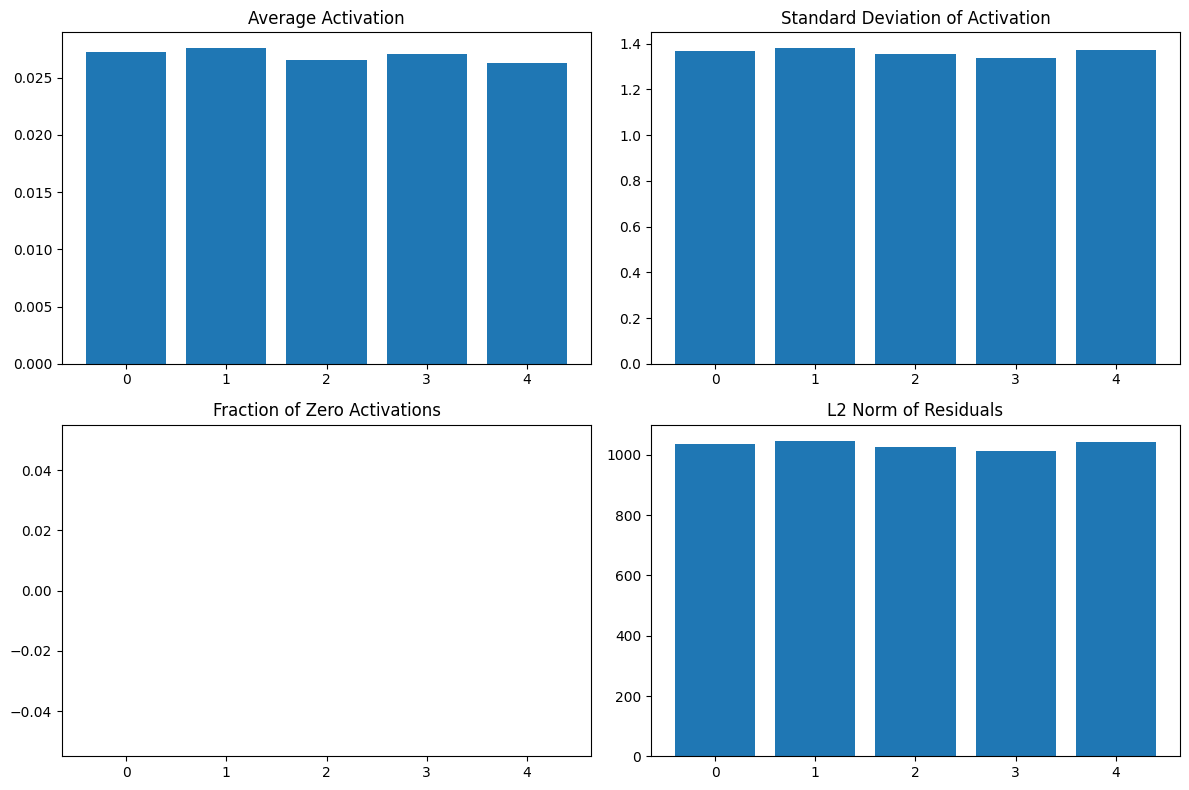

In [23]:
import torch
import matplotlib.pyplot as plt
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# Instantiate a new model and processor
model_name = "openai/whisper-tiny"  # or whichever model you were using before
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)
processor = WhisperProcessor.from_pretrained(model_name)

def analyze_residuals(hidden_states):
    # Compute average activation
    avg_activation = hidden_states.mean().item()
    
    # Compute standard deviation of activation
    std_activation = hidden_states.std().item()
    
    # Compute fraction of zero activations
    zero_fraction = (hidden_states == 0).float().mean().item()
    
    # Compute L2 norm of residuals
    l2_norm = torch.norm(hidden_states).item()
    
    return {
        "avg_activation": avg_activation,
        "std_activation": std_activation,
        "zero_fraction": zero_fraction,
        "l2_norm": l2_norm
    }

# Analyze residual stream
residual_analyses = []

for i, sample in enumerate(processed_samples):
    print(f"\nProcessing sample {i+1}")
    input_features = sample["input_features"].unsqueeze(0).to(device)
    print(f"Input features shape: {input_features.shape}")
    
    with torch.no_grad():
        try:
            encoder_outputs = model.model.encoder(
                input_features,
                attention_mask=None,
                head_mask=None,
                output_attentions=None,
                output_hidden_states=True,
                return_dict=True
            )
            print("Encoder forward pass successful")
            print(f"Encoder outputs type: {type(encoder_outputs)}")
            print(f"Encoder outputs keys: {encoder_outputs.keys() if hasattr(encoder_outputs, 'keys') else 'N/A'}")
        except Exception as e:
            print(f"Error during encoder forward pass: {str(e)}")
            continue
    
    # Analyze the last hidden state (residual stream)
    last_hidden_state = encoder_outputs.last_hidden_state
    residual_analysis = analyze_residuals(last_hidden_state)
    residual_analyses.append(residual_analysis)
    
    print(f"Sample {len(residual_analyses)}:")
    print(f"Reference text: {sample['reference_text']}")
    print(f"Transcription: {sample['transcription']}")
    print("Residual Analysis:")
    for key, value in residual_analysis.items():
        print(f"  {key}: {value}")
    print("---")

print(f"Total processed and analyzed samples: {len(residual_analyses)}")

# Visualization code
if residual_analyses:
    avg_activations = [analysis['avg_activation'] for analysis in residual_analyses]
    std_activations = [analysis['std_activation'] for analysis in residual_analyses]
    zero_fractions = [analysis['zero_fraction'] for analysis in residual_analyses]
    l2_norms = [analysis['l2_norm'] for analysis in residual_analyses]

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.bar(range(len(avg_activations)), avg_activations)
    plt.title('Average Activation')
    plt.subplot(2, 2, 2)
    plt.bar(range(len(std_activations)), std_activations)
    plt.title('Standard Deviation of Activation')
    plt.subplot(2, 2, 3)
    plt.bar(range(len(zero_fractions)), zero_fractions)
    plt.title('Fraction of Zero Activations')
    plt.subplot(2, 2, 4)
    plt.bar(range(len(l2_norms)), l2_norms)
    plt.title('L2 Norm of Residuals')
    plt.tight_layout()
    plt.show()
else:
    print("No samples were successfully analyzed.")


Processing sample 1
Input features shape: torch.Size([1, 80, 3000])
Encoder forward pass successful
Encoder outputs type: <class 'transformers.modeling_outputs.BaseModelOutput'>
Encoder outputs keys: odict_keys(['last_hidden_state', 'hidden_states', 'attentions'])
Attention weights type: <class 'tuple'>
Number of layers: 4
Layer 1 attention shape: torch.Size([1, 6, 1500, 1500])
Layer 2 attention shape: torch.Size([1, 6, 1500, 1500])
Layer 3 attention shape: torch.Size([1, 6, 1500, 1500])
Layer 4 attention shape: torch.Size([1, 6, 1500, 1500])
Sample 1:
Reference text: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
Transcription:  Chapter 16 I might have told you of the beginning of this liaison in a few lines, but I wanted you to see every step by which we came. I to agree to whatever Mark Reid wished.
---


IndexError: index 1 is out of bounds for dimension 0 with size 1

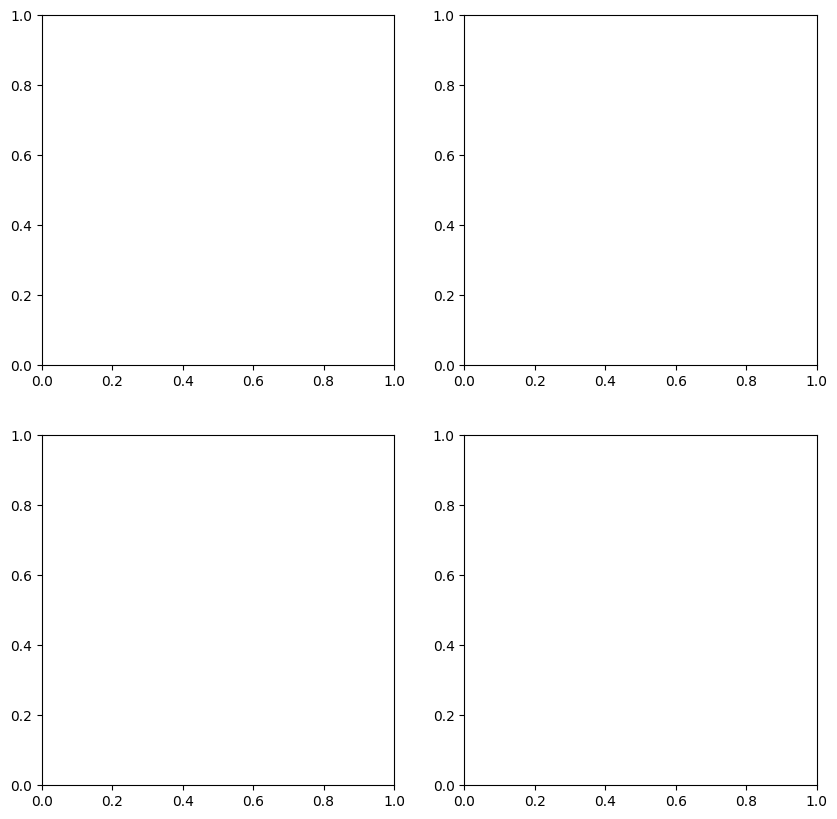

In [11]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# Instantiate a new model and processor
model_name = "openai/whisper-tiny"
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)
processor = WhisperProcessor.from_pretrained(model_name)

def analyze_attention(attention_weights):
    print(f"Attention weights type: {type(attention_weights)}")
    print(f"Number of layers: {len(attention_weights)}")
    
    avg_attention = []
    entropy = []
    
    for i, layer_attention in enumerate(attention_weights):
        print(f"Layer {i+1} attention shape: {layer_attention.shape}")
        
        # Compute average attention across heads for this layer
        avg_layer_attention = layer_attention.mean(dim=1)
        avg_attention.append(avg_layer_attention)
        
        # Compute entropy of attention distributions for this layer
        layer_entropy = -(layer_attention * torch.log(layer_attention + 1e-9)).sum(dim=-1).mean(dim=-1)
        entropy.append(layer_entropy)
    
    return {
        "avg_attention": avg_attention,
        "entropy": torch.stack(entropy)
    }

# Analyze attention patterns
attention_analyses = []

for i, sample in enumerate(processed_samples[:1]):  # Let's start with just the first sample
    print(f"\nProcessing sample {i+1}")
    input_features = sample["input_features"].unsqueeze(0).to(device)
    print(f"Input features shape: {input_features.shape}")
    
    with torch.no_grad():
        try:
            encoder_outputs = model.model.encoder(
                input_features,
                attention_mask=None,
                head_mask=None,
                output_attentions=True,
                output_hidden_states=True,
                return_dict=True
            )
            print("Encoder forward pass successful")
            print(f"Encoder outputs type: {type(encoder_outputs)}")
            print(f"Encoder outputs keys: {encoder_outputs.keys() if hasattr(encoder_outputs, 'keys') else 'N/A'}")
        except Exception as e:
            print(f"Error during encoder forward pass: {str(e)}")
            continue
    
    attention_weights = encoder_outputs.attentions
    attention_analysis = analyze_attention(attention_weights)
    attention_analyses.append(attention_analysis)
    
    print(f"Sample {i+1}:")
    print(f"Reference text: {sample['reference_text']}")
    print(f"Transcription: {sample['transcription']}")
    print("---")

# Visualize attention patterns for the first sample
if attention_analyses:
    analysis = attention_analyses[0]
    num_layers = len(analysis['avg_attention'])
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    
    for layer in range(num_layers):
        # Select the first head's attention pattern
        attention_map = analysis['avg_attention'][layer][0].cpu().numpy()
        
        sns.heatmap(attention_map, ax=axes[layer], cmap='viridis', cbar=False)
        axes[layer].set_title(f'Layer {layer+1} Attention (averaged across heads)')
        axes[layer].set_xlabel('Key')
        axes[layer].set_ylabel('Query')
        axes[layer].axis('off')  # Turn off axis labels for cleaner look
    
    plt.tight_layout()
    plt.show()
    
    # Plot entropy
    plt.figure(figsize=(10, 5))
    plt.plot(analysis['entropy'].cpu().numpy().flatten())
    plt.title('Attention Entropy across Layers and Heads')
    plt.xlabel('Layer * Num_Heads + Head_Index')
    plt.ylabel('Entropy')
    plt.show()
else:
    print("No samples were successfully analyzed.")

Shape of attention_analyses: 1
Shape of avg_attention: 4
Shape of first layer attention: torch.Size([1, 1500, 1500])
First layer attention statistics:
Min: 0.0000
Max: 0.2482
Mean: 0.0007
Std: 0.0062


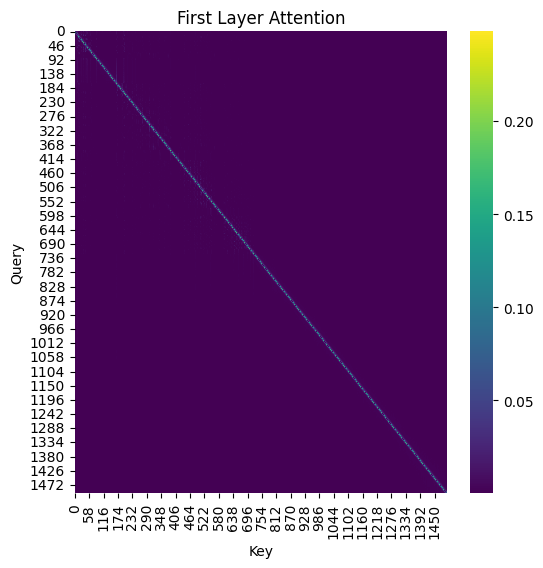

IndexError: list index out of range

In [8]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Print the shape of our attention weights
print("Shape of attention_analyses:", len(attention_analyses))
print("Shape of avg_attention:", len(attention_analyses[0]['avg_attention']))
print("Shape of first layer attention:", attention_analyses[0]['avg_attention'][0].shape)

# Let's look at the first layer's attention
first_layer_attention = attention_analyses[0]['avg_attention'][0].squeeze(0)  # Remove the first dimension
print("First layer attention statistics:")
print(f"Min: {first_layer_attention.min().item():.4f}")
print(f"Max: {first_layer_attention.max().item():.4f}")
print(f"Mean: {first_layer_attention.mean().item():.4f}")
print(f"Std: {first_layer_attention.std().item():.4f}")

# Visualize the first layer's attention
plt.figure(figsize=(6, 6))
sns.heatmap(first_layer_attention.cpu().numpy(), cmap='viridis')
plt.title("First Layer Attention")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()

# Function to visualize multi-head attention
def visualize_multi_head_attention(attention_weights, layer=4):  # Layer 5 (0-indexed)
    layer_attention = attention_weights[layer].squeeze(0)  # Shape: (1500, 1500)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(layer_attention.cpu().numpy(), cmap='viridis')
    plt.title(f'Layer {layer+1} Attention')
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.show()
    
    print(f"Layer {layer+1} attention statistics:")
    print(f"Min attention value: {layer_attention.min().item():.4f}")
    print(f"Max attention value: {layer_attention.max().item():.4f}")
    print(f"Mean attention value: {layer_attention.mean().item():.4f}")
    print(f"Standard deviation of attention: {layer_attention.std().item():.4f}")

# Visualize multi-head attention for layer 5
visualize_multi_head_attention(attention_analyses[0]['avg_attention'])

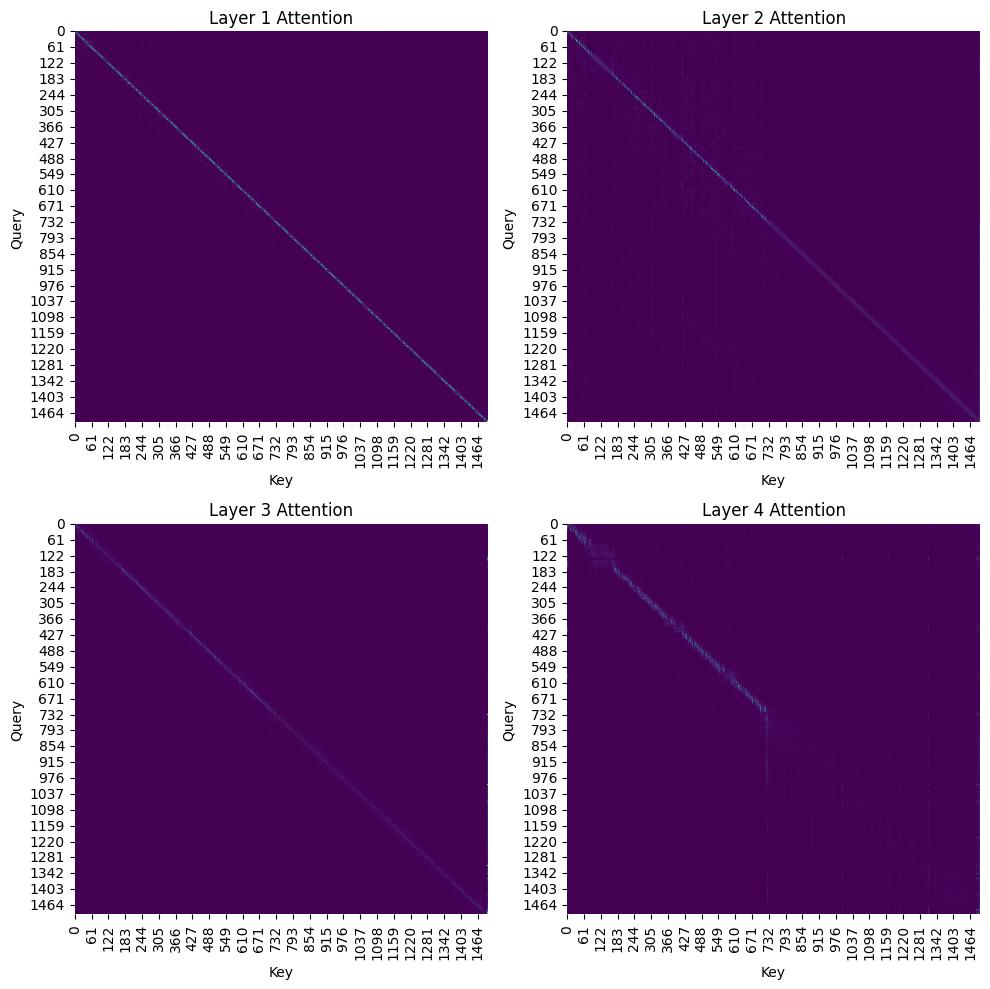

Layer 1 attention statistics:
Min attention value: 0.0000
Max attention value: 0.2482
Mean attention value: 0.0007
Standard deviation of attention: 0.0062

Layer 2 attention statistics:
Min attention value: 0.0000
Max attention value: 0.1559
Mean attention value: 0.0007
Standard deviation of attention: 0.0024

Layer 3 attention statistics:
Min attention value: 0.0000
Max attention value: 0.4114
Mean attention value: 0.0007
Standard deviation of attention: 0.0033

Layer 4 attention statistics:
Min attention value: 0.0000
Max attention value: 0.2126
Mean attention value: 0.0007
Standard deviation of attention: 0.0041



In [10]:
def visualize_all_layers(attention_weights):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    
    for layer in range(4):
        layer_attention = attention_weights[layer].squeeze(0)
        sns.heatmap(layer_attention.cpu().numpy(), ax=axes[layer], cmap='viridis', cbar=False)
        axes[layer].set_title(f'Layer {layer+1} Attention')
        axes[layer].set_xlabel('Key')
        axes[layer].set_ylabel('Query')
    
    plt.tight_layout()
    plt.show()

    for layer in range(4):
        layer_attention = attention_weights[layer].squeeze(0)
        print(f"Layer {layer+1} attention statistics:")
        print(f"Min attention value: {layer_attention.min().item():.4f}")
        print(f"Max attention value: {layer_attention.max().item():.4f}")
        print(f"Mean attention value: {layer_attention.mean().item():.4f}")
        print(f"Standard deviation of attention: {layer_attention.std().item():.4f}")
        print()

# Visualize all layers
visualize_all_layers(attention_analyses[0]['avg_attention'])


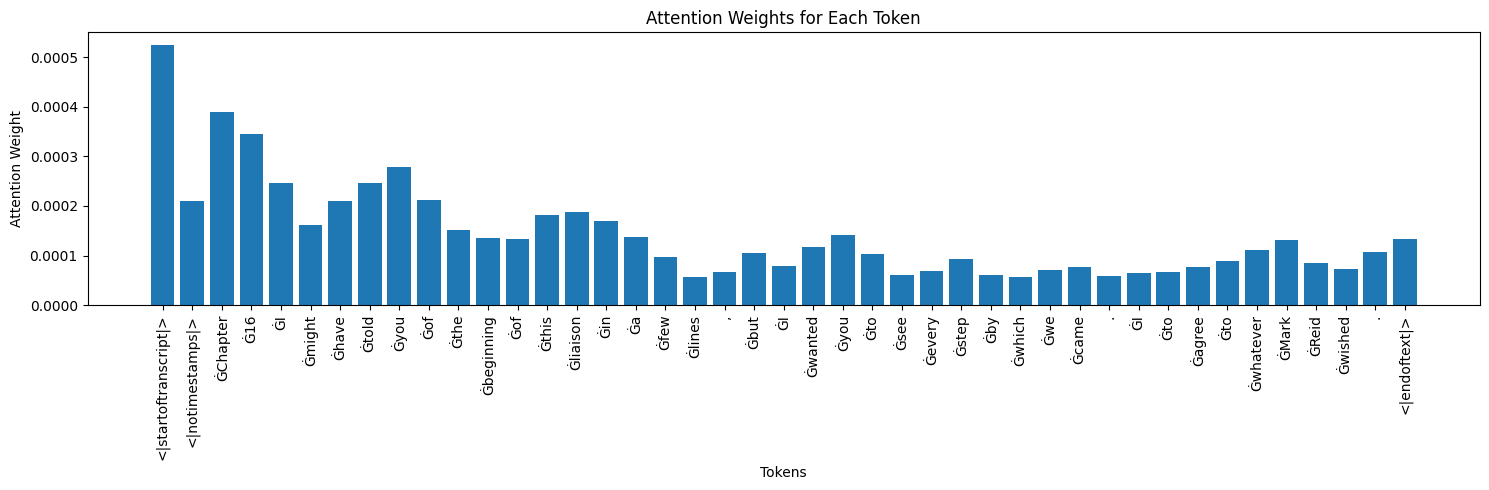

Token: <|startoftranscript|>, Attention Weight: 0.0005
Token: <|notimestamps|>, Attention Weight: 0.0002
Token: ĠChapter, Attention Weight: 0.0004
Token: Ġ16, Attention Weight: 0.0003
Token: ĠI, Attention Weight: 0.0002
Token: Ġmight, Attention Weight: 0.0002
Token: Ġhave, Attention Weight: 0.0002
Token: Ġtold, Attention Weight: 0.0002
Token: Ġyou, Attention Weight: 0.0003
Token: Ġof, Attention Weight: 0.0002
Token: Ġthe, Attention Weight: 0.0002
Token: Ġbeginning, Attention Weight: 0.0001
Token: Ġof, Attention Weight: 0.0001
Token: Ġthis, Attention Weight: 0.0002
Token: Ġliaison, Attention Weight: 0.0002
Token: Ġin, Attention Weight: 0.0002
Token: Ġa, Attention Weight: 0.0001
Token: Ġfew, Attention Weight: 0.0001
Token: Ġlines, Attention Weight: 0.0001
Token: ,, Attention Weight: 0.0001
Token: Ġbut, Attention Weight: 0.0001
Token: ĠI, Attention Weight: 0.0001
Token: Ġwanted, Attention Weight: 0.0001
Token: Ġyou, Attention Weight: 0.0001
Token: Ġto, Attention Weight: 0.0001
Token: Ġsee

In [6]:
import torch
from transformers import WhisperTokenizer

# Initialize the tokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny")

def map_attention_to_text(attention_weights, text):
    # Tokenize the text
    tokens = tokenizer.encode(text)
    token_text = tokenizer.convert_ids_to_tokens(tokens)

    # Get the last layer's attention (assuming it's most relevant for the final output)
    last_layer_attention = attention_weights[-1].squeeze(0)

    # We'll focus on the attention of the last token (which likely corresponds to the [EOS] token)
    last_token_attention = last_layer_attention[-1, :len(tokens)]

    # Create a bar plot of attention weights for each token
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(token_text)), last_token_attention.cpu().numpy())
    plt.xticks(range(len(token_text)), token_text, rotation=90)
    plt.xlabel('Tokens')
    plt.ylabel('Attention Weight')
    plt.title('Attention Weights for Each Token')
    plt.tight_layout()
    plt.show()

    # Print tokens with their attention weights
    for token, weight in zip(token_text, last_token_attention):
        print(f"Token: {token}, Attention Weight: {weight.item():.4f}")

# Use the function
text = processed_samples[0]['transcription']
map_attention_to_text(attention_analyses[0]['avg_attention'], text)

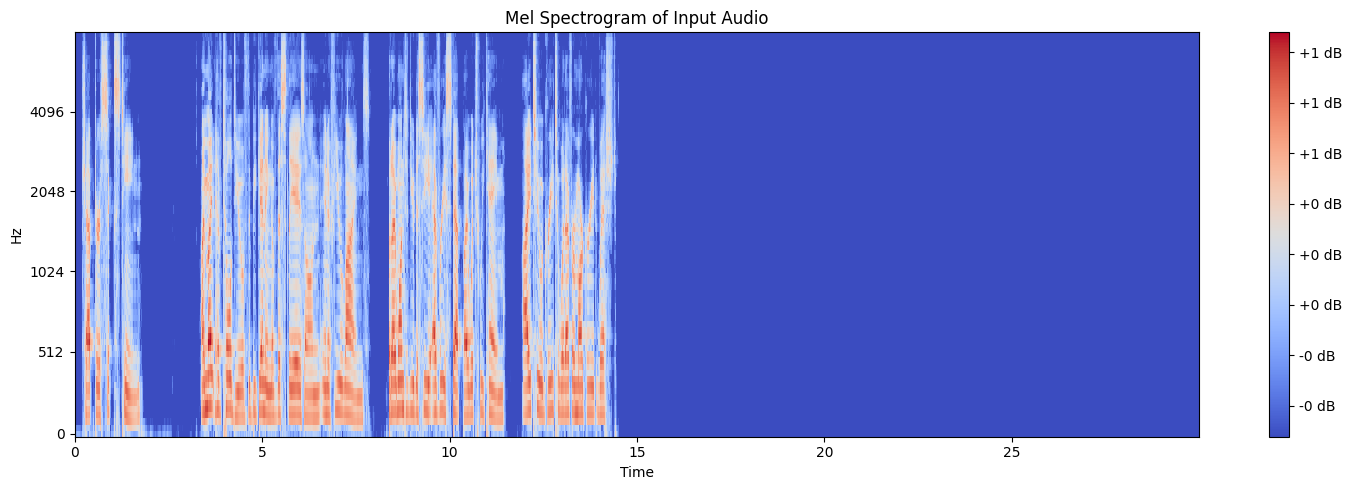

Input feature shape: torch.Size([80, 3000])
Min value: -0.6520
Max value: 1.3480
Mean value: -0.3875
Std deviation: 0.4305
6


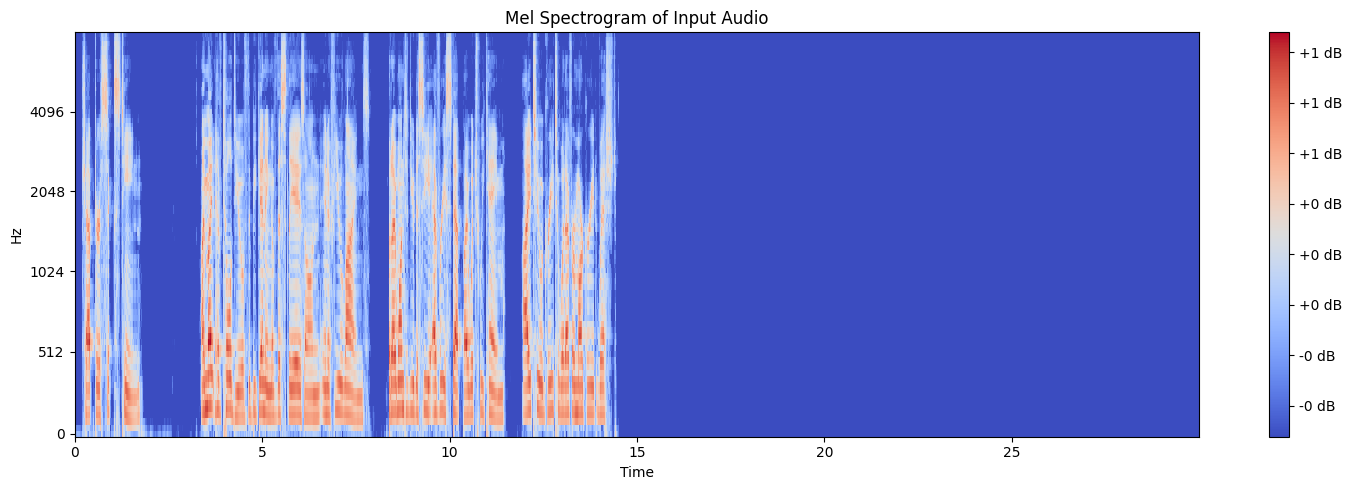

IndexError: index 4 is out of bounds for axis 0 with size 4

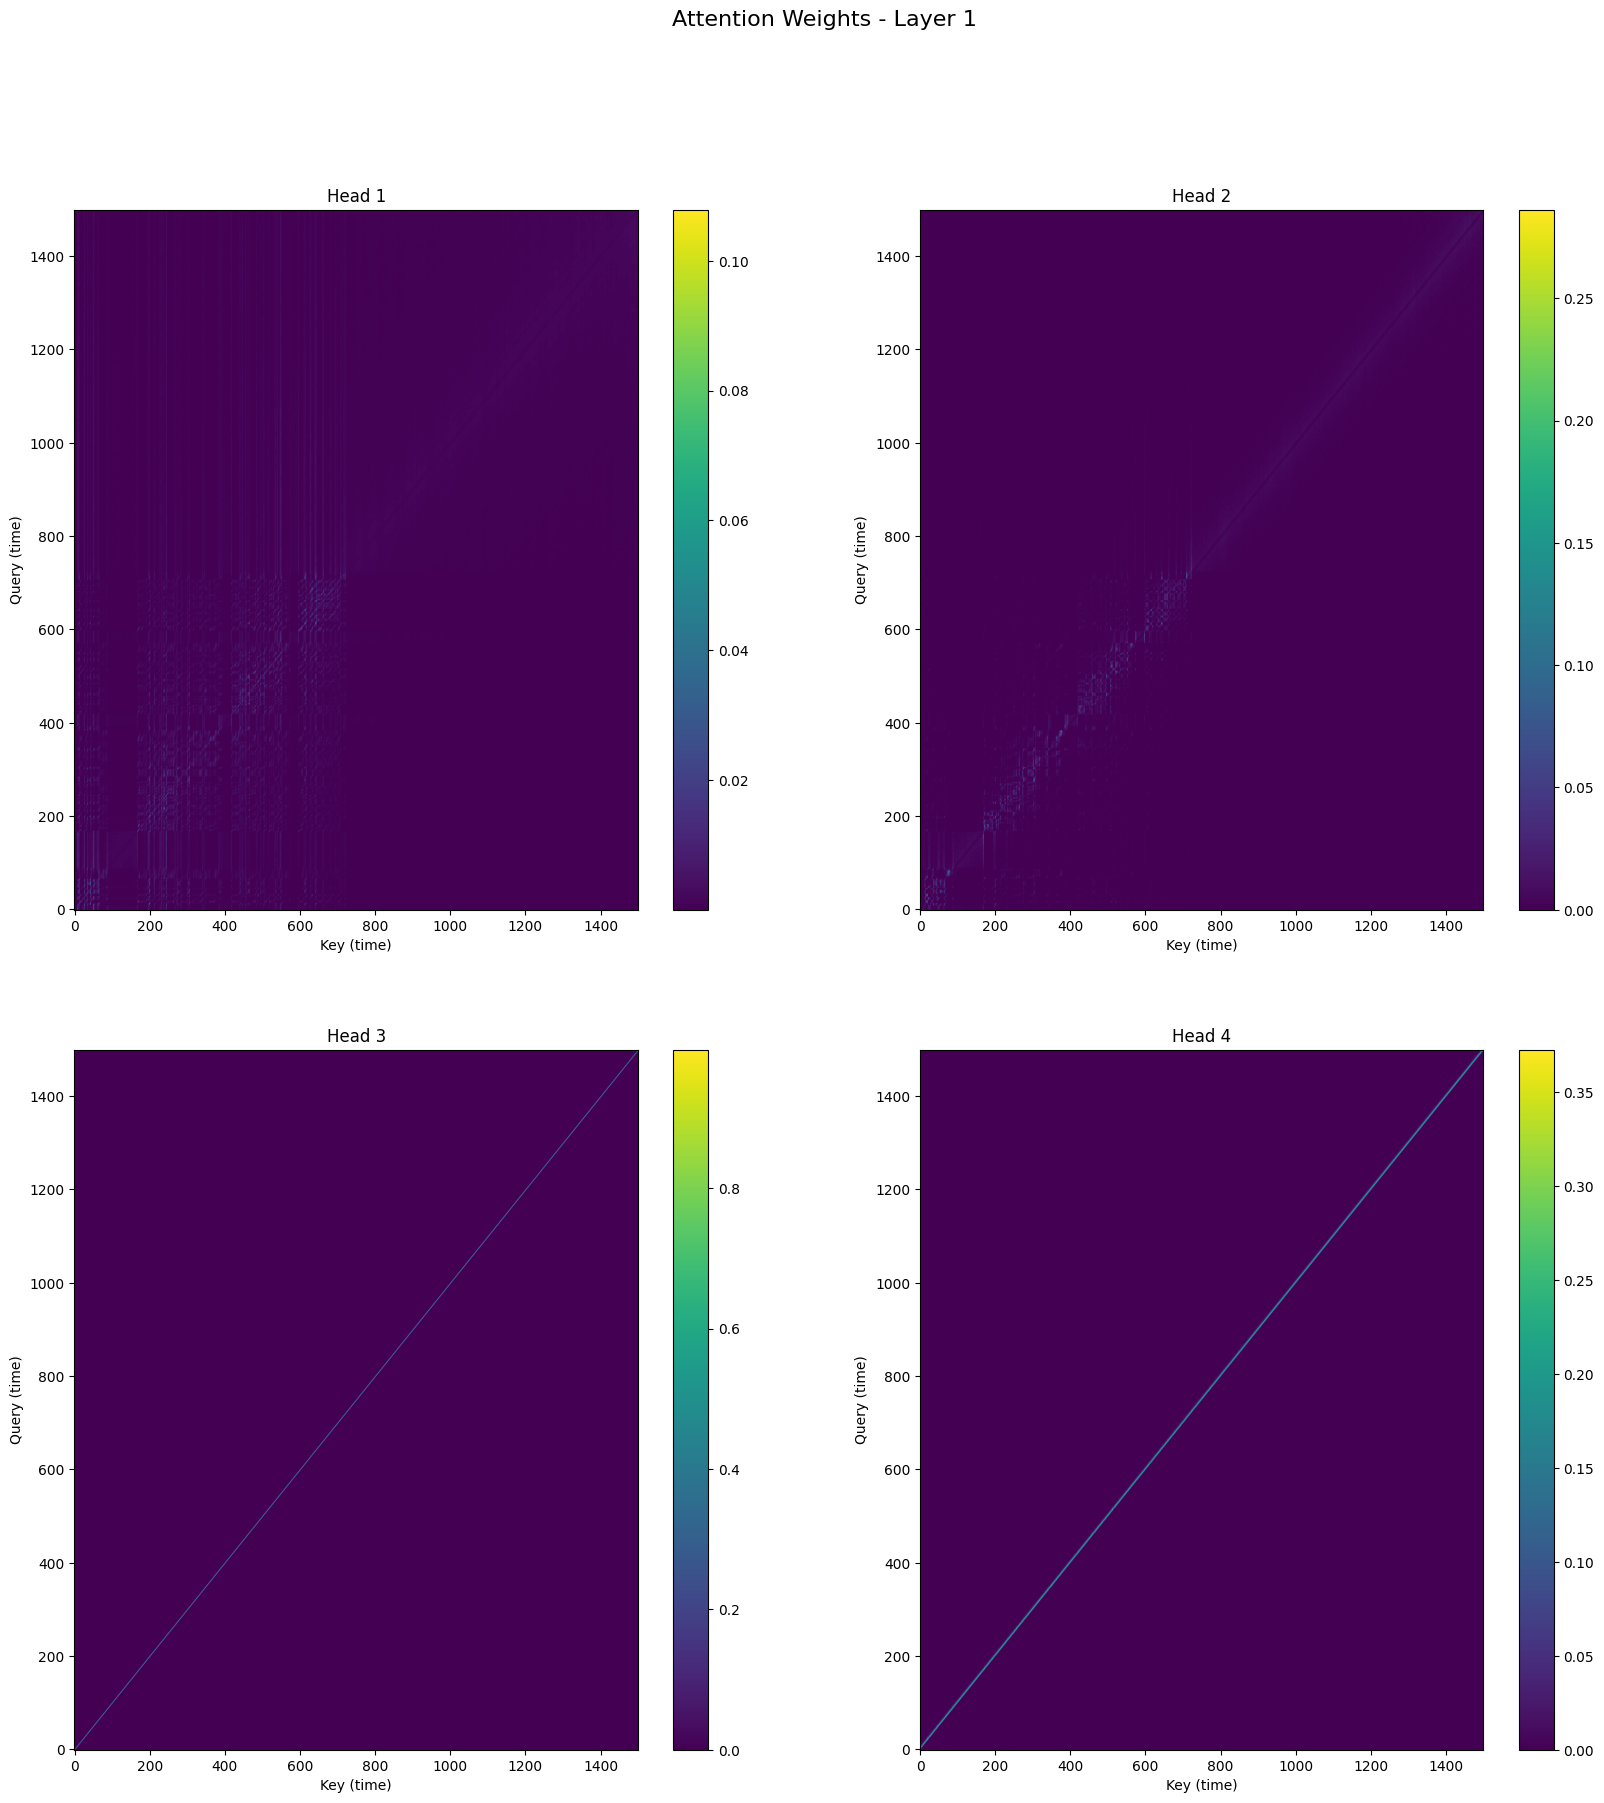

In [17]:
import torch
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Whisper Tiny model and processor
model_name = "openai/whisper-tiny"
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)
processor = WhisperProcessor.from_pretrained(model_name)

def get_attention_weights(sample):
    input_features = sample["input_features"].unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model.model.encoder(
            input_features,
            output_attentions=True,
            return_dict=True
        )
    
    return outputs.attentions

def visualize_audio_features(input_features):
    mel_spec = input_features.squeeze().cpu().numpy()
    
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=16000, hop_length=160)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram of Input Audio')
    plt.tight_layout()
    plt.show()

    print(f"Input feature shape: {input_features.shape}")
    print(f"Min value: {input_features.min().item():.4f}")
    print(f"Max value: {input_features.max().item():.4f}")
    print(f"Mean value: {input_features.mean().item():.4f}")
    print(f"Std deviation: {input_features.std().item():.4f}")

def compare_audio_and_all_attention(input_features, attention_weights):
    mel_spec = input_features.squeeze().cpu().numpy()
    num_layers = len(attention_weights)
    num_heads = attention_weights[0].shape[1]
    print(num_heads)
    # Plot mel spectrogram
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=16000, hop_length=160)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram of Input Audio')
    plt.tight_layout()
    plt.show()

    # Plot attention for each layer and head
    for layer in range(num_layers):
        fig, axes = plt.subplots(2, 2, figsize=(20, 20))
        fig.suptitle(f'Attention Weights - Layer {layer+1}', fontsize=16)
        axes = axes.flatten()

        for head in range(num_heads):
            selected_attention = attention_weights[layer][0, head].cpu().numpy()
            
            im = axes[head].imshow(selected_attention, aspect='auto', origin='lower')
            axes[head].set_title(f'Head {head+1}')
            axes[head].set_xlabel('Key (time)')
            axes[head].set_ylabel('Query (time)')
            fig.colorbar(im, ax=axes[head])

        plt.tight_layout()
        plt.show()

new_sample_index = 0  # Change this to select a different sample
new_sample = processed_samples[new_sample_index]

# Get attention weights
attention_weights = get_attention_weights(new_sample)

# Use the existing sample and analysis
input_features = new_sample["input_features"]
visualize_audio_features(input_features)

# Compare audio features with attention for all layers and heads
compare_audio_and_all_attention(input_features, attention_weights)

print("\nTranscription of the sample:")
print(new_sample["transcription"])

{'input_features': tensor([[ 0.0428, -0.0523, -0.1343,  ..., -0.6520, -0.6520, -0.6520],
         [-0.1651, -0.2152, -0.3480,  ..., -0.6520, -0.6520, -0.6520],
         [-0.4397, -0.4487, -0.6013,  ..., -0.6520, -0.6520, -0.6520],
         ...,
         [-0.6520, -0.6520, -0.6520,  ..., -0.6520, -0.6520, -0.6520],
         [-0.6520, -0.6520, -0.6520,  ..., -0.6520, -0.6520, -0.6520],
         [-0.6520, -0.6520, -0.6520,  ..., -0.6520, -0.6520, -0.6520]]),
 'reference_text': 'CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED',
 'audio_duration': 14.53,
 'transcription': ' Chapter 16 I might have told you of the beginning of this liaison in a few lines, but I wanted you to see every step by which we came. I to agree to whatever Mark Reid wished.'}

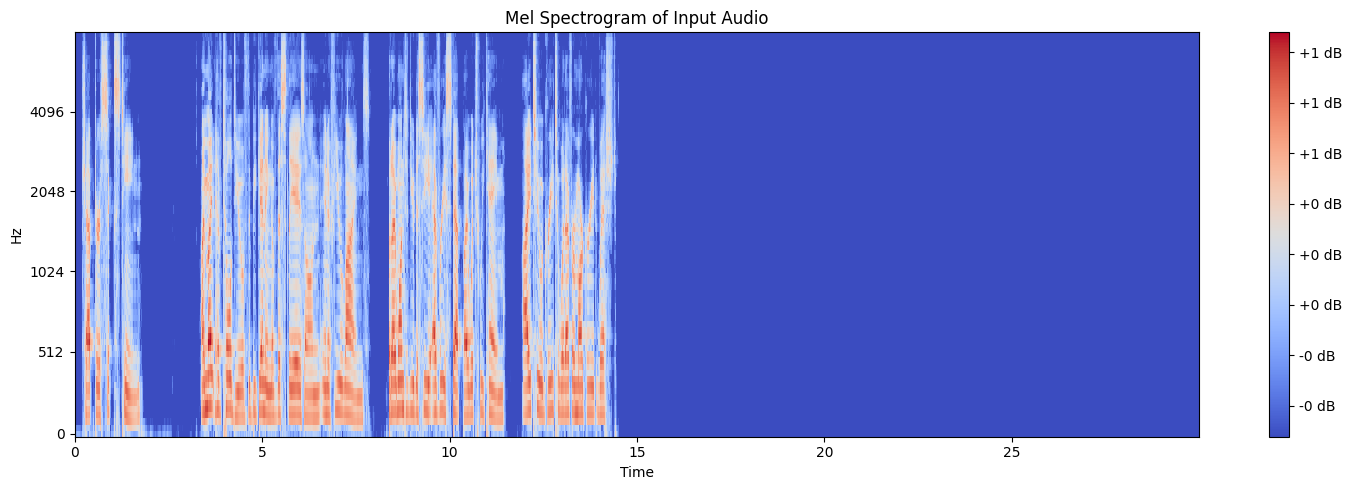

Input feature shape: torch.Size([80, 3000])
Min value: -0.6520
Max value: 1.3480
Mean value: -0.3875
Std deviation: 0.4305
Mel spectrogram shape: (80, 3000)
Attention weights shape: (1500, 1500)


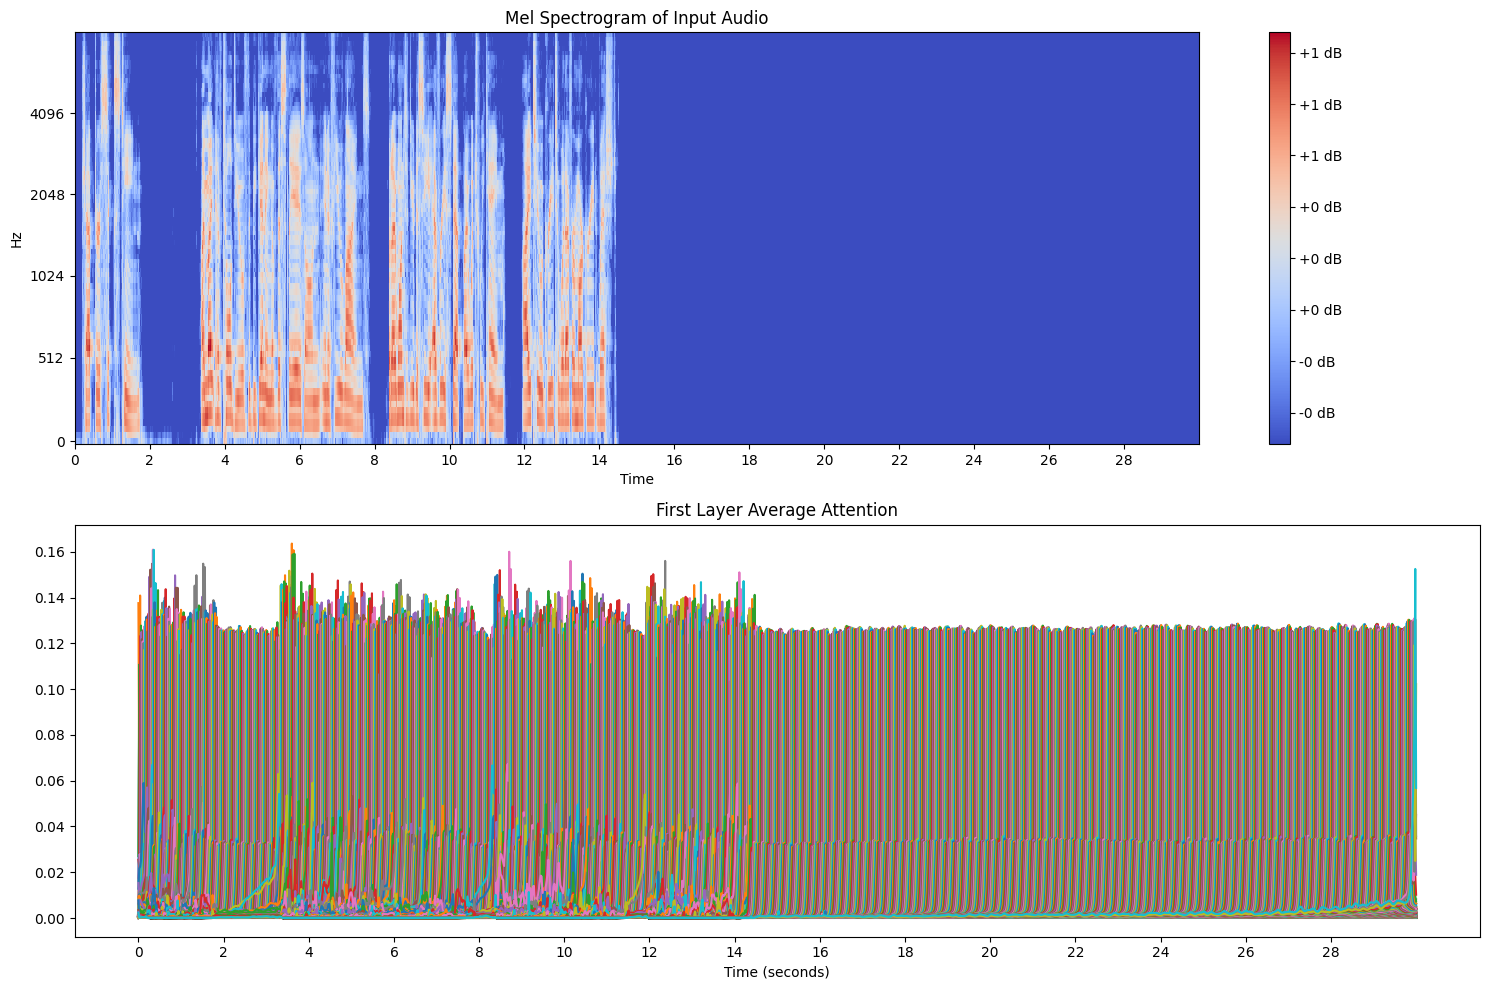


Transcription of the sample:
 Chapter 16 I might have told you of the beginning of this liaison in a few lines, but I wanted you to see every step by which we came. I to agree to whatever Mark Reid wished.


In [11]:
import torch
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

def visualize_audio_features(input_features):
    mel_spec = input_features.squeeze().cpu().numpy()
    
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=16000, hop_length=160)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram of Input Audio')
    plt.tight_layout()
    plt.show()

    print(f"Input feature shape: {input_features.shape}")
    print(f"Min value: {input_features.min().item():.4f}")
    print(f"Max value: {input_features.max().item():.4f}")
    print(f"Mean value: {input_features.mean().item():.4f}")
    print(f"Std deviation: {input_features.std().item():.4f}")

def compare_audio_and_attention(input_features, avg_attention):
    mel_spec = input_features.squeeze().cpu().numpy()
    first_layer_attention = avg_attention[0].mean(dim=0).cpu().numpy()

    print(f"Mel spectrogram shape: {mel_spec.shape}")
    print(f"Attention weights shape: {first_layer_attention.shape}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Calculate time axis for mel spectrogram
    num_frames_mel = mel_spec.shape[1]
    duration_mel = (num_frames_mel * 160) / 16000
    time_axis_mel = np.linspace(0, duration_mel, num_frames_mel)

    # Calculate time axis for attention
    num_frames_att = len(first_layer_attention)
    duration_att = duration_mel  # Assume same total duration
    time_axis_att = np.linspace(0, duration_att, num_frames_att)

    # Plot mel spectrogram
    img = librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=16000, hop_length=160, ax=ax1)
    ax1.set_title('Mel Spectrogram of Input Audio')
    fig.colorbar(img, ax=ax1, format='%+2.0f dB')

    # Plot attention
    ax2.plot(time_axis_att, first_layer_attention)
    ax2.set_title('First Layer Average Attention')
    ax2.set_xlabel('Time (seconds)')

    # Set x-axis ticks
    max_time = int(np.ceil(duration_mel))
    ax1.set_xticks(np.arange(0, max_time, 2))
    ax2.set_xticks(np.arange(0, max_time, 2))

    plt.tight_layout()
    plt.show()

new_sample_index = 0  # Change this to select a different sample
new_sample = processed_samples[new_sample_index]

# Use the existing sample and analysis
input_features = new_sample["input_features"]
visualize_audio_features(input_features)

# Compare audio features with attention
compare_audio_and_attention(input_features, attention_analyses[new_sample_index]['avg_attention'])

print("\nTranscription of the sample:")
print(new_sample["transcription"])

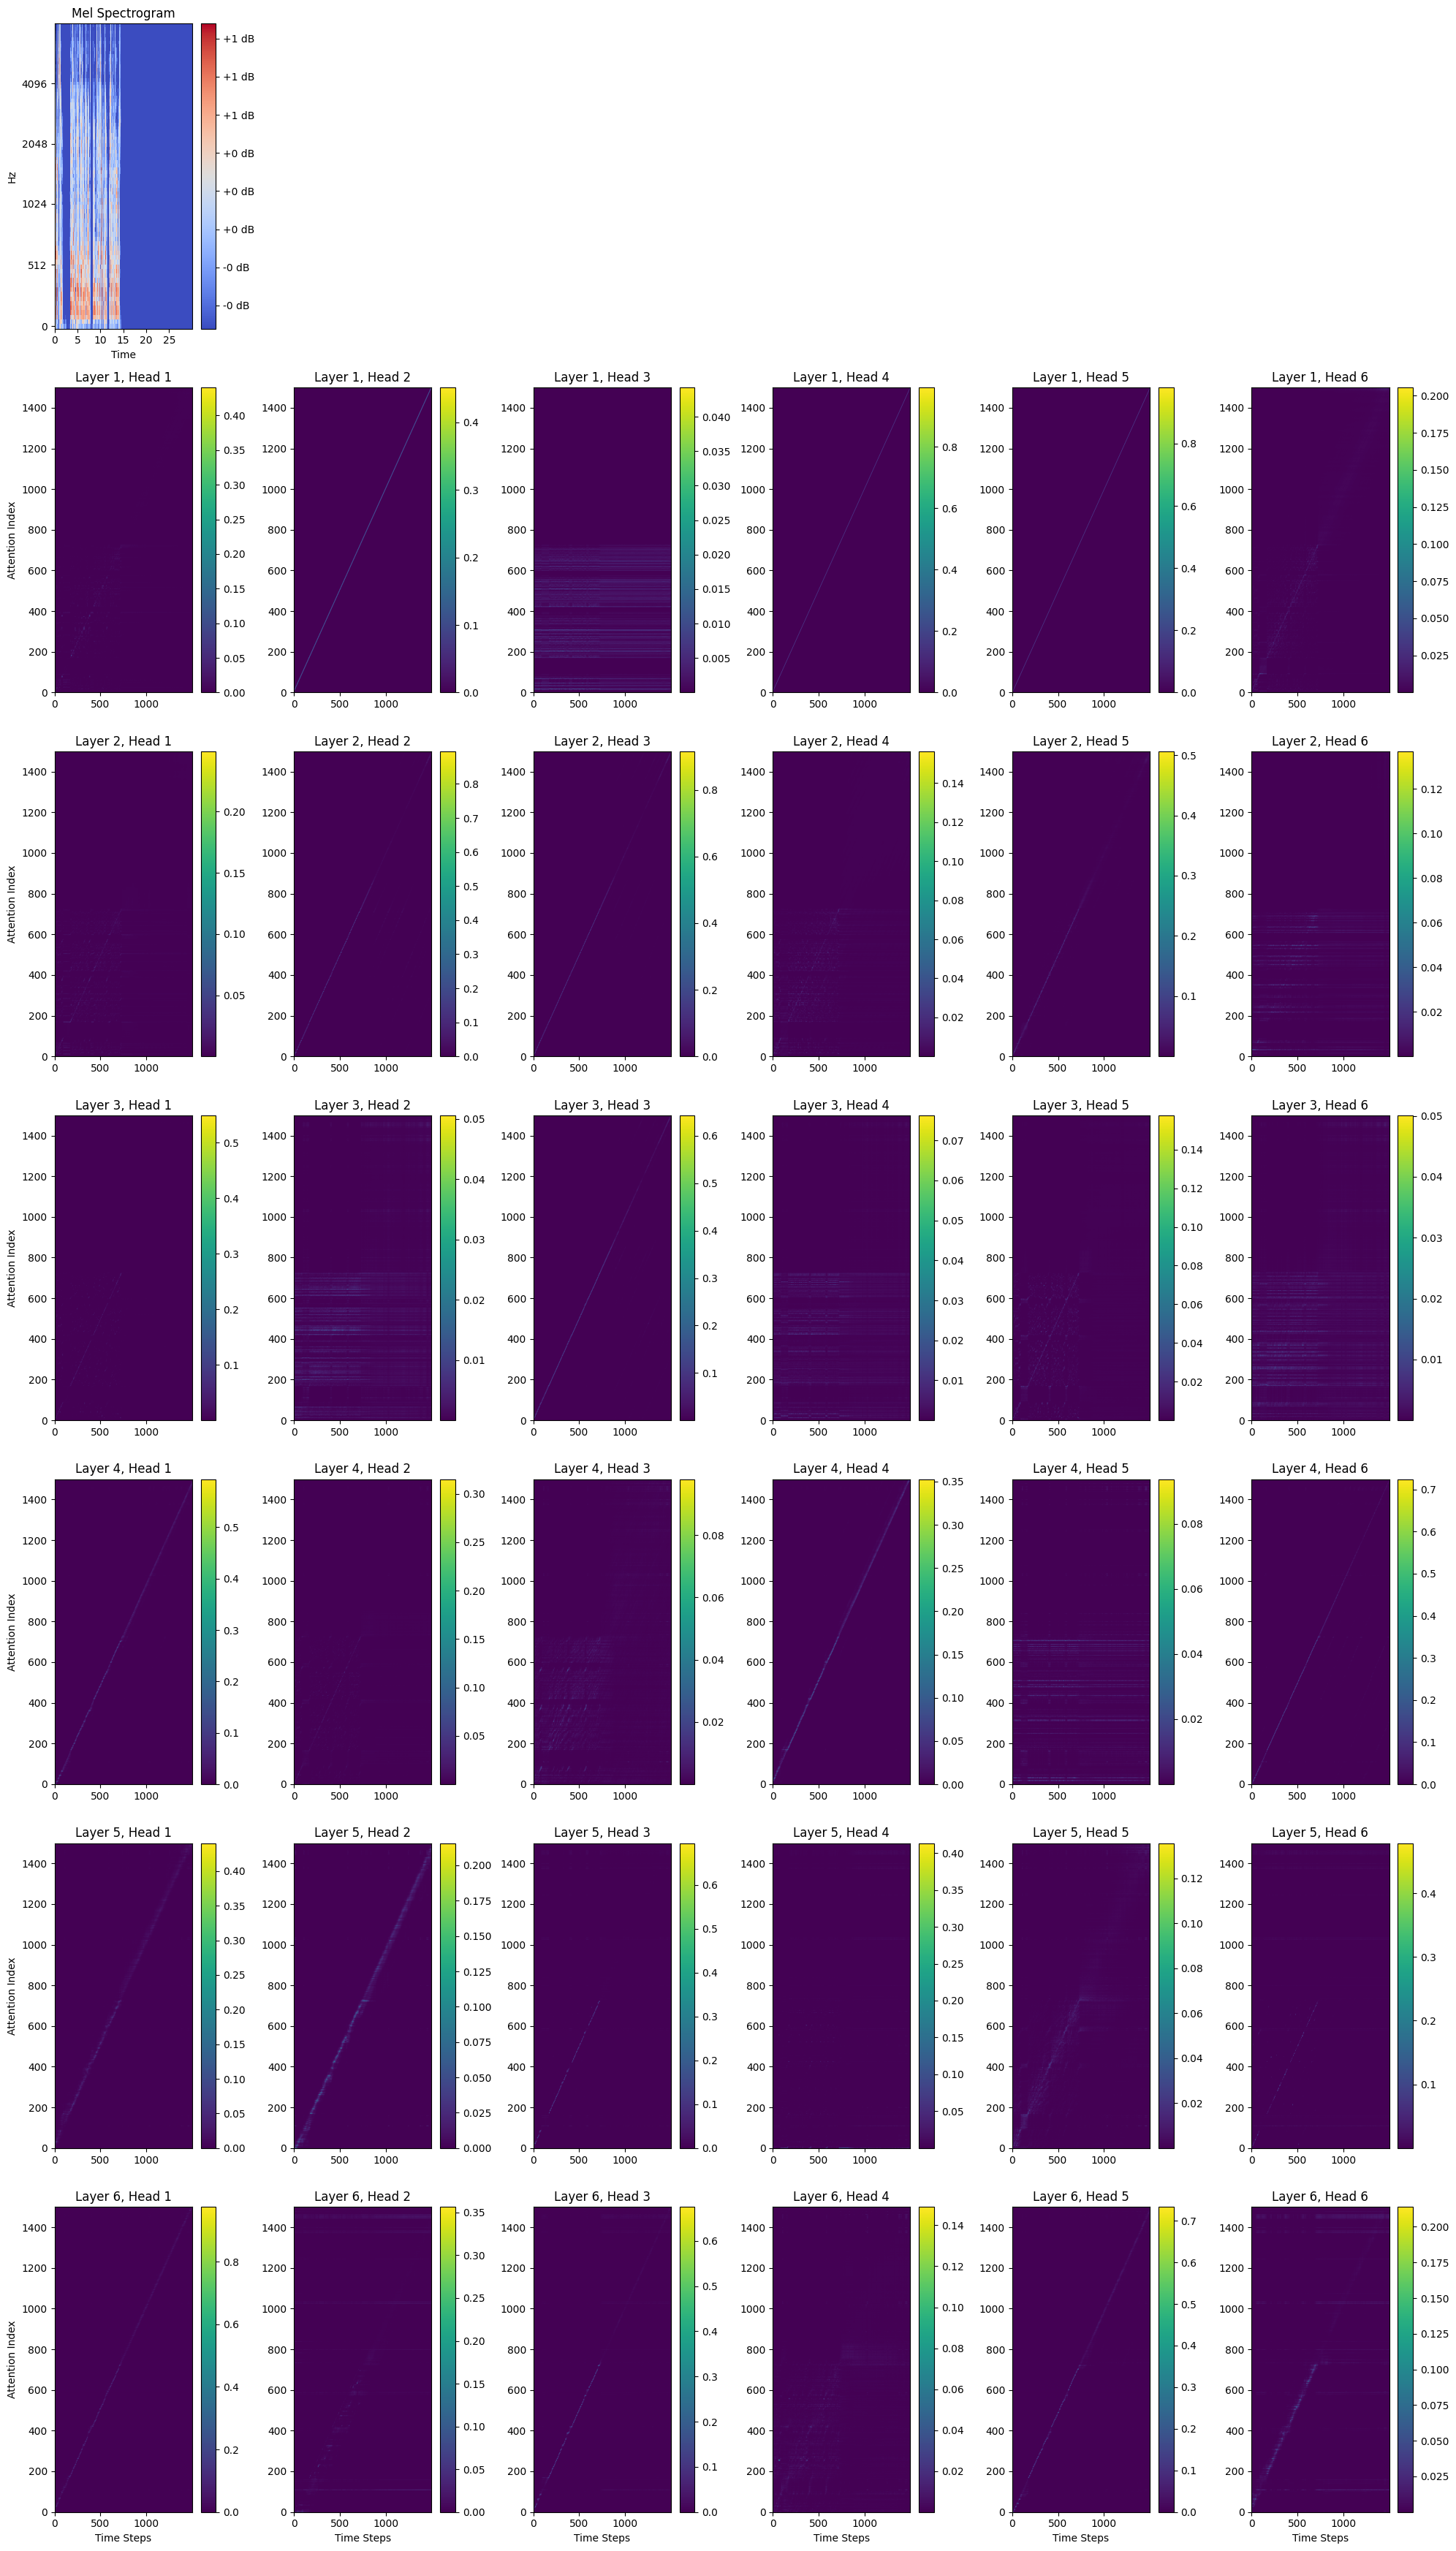


Transcription of the sample:
 Chapter 16. I might have told you of the beginning of this liaison in a few lines, but I wanted you to see every step by which we came. I too agreed to whatever Markerite wished.


In [43]:
import torch
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

def visualize_multi_head_attention(input_features, attention_weights, num_layers=6, num_heads=6):
    mel_spec = input_features.squeeze().cpu().numpy()
    
    fig, axs = plt.subplots(num_layers + 1, num_heads, figsize=(20, 5 * (num_layers + 1)))
    
    img = librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=16000, hop_length=160, ax=axs[0, 0])
    axs[0, 0].set_title('Mel Spectrogram')
    plt.colorbar(img, ax=axs[0, 0], format='%+2.0f dB')

    
    for col in range(1, num_heads):
        axs[0, col].axis('off')
    
    # Plot attention heatmaps
    for layer in range(num_layers):
        for head in range(num_heads):
            attention = attention_weights[layer][0, head].cpu().numpy()
            normalized_attention = attention / attention.sum(axis=1, keepdims=True)
            
            im = axs[layer + 1, head].imshow(normalized_attention.T, aspect='auto', origin='lower')
            axs[layer + 1, head].set_title(f'Layer {layer + 1}, Head {head + 1}')
            fig.colorbar(im, ax=axs[layer + 1, head])
            
            if head == 0:
                axs[layer + 1, head].set_ylabel('Attention Index')
            if layer == num_layers - 1:
                axs[layer + 1, head].set_xlabel('Time Steps')
    
    plt.tight_layout()
    plt.show()

# Use the function
visualize_multi_head_attention(sample_analysis["input_features"], sample_analysis["attention"])

# Print transcription
print("\nTranscription of the sample:")
print(sample["transcription"])

In [12]:
from transformers import WhisperTokenizer

def align_attention_with_transcription(attention_weights, transcription, tokenizer):
    # Tokenize the transcription
    tokens = tokenizer.encode(transcription)
    token_texts = tokenizer.convert_ids_to_tokens(tokens)
    
    # Get the last layer's attention (assuming it's most relevant for the final output)
    last_layer_attention = attention_weights[-1][0].mean(dim=0).cpu().numpy()
    
    # The attention might be longer than the number of tokens, so we'll need to adjust
    attention_per_token = last_layer_attention[:len(tokens)]
    
    # Create a plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot heatmap of attention
    im = ax1.imshow(attention_per_token.T, aspect='auto', origin='lower')
    ax1.set_title('Last Layer Attention')
    ax1.set_xlabel('Token Index')
    ax1.set_ylabel('Attention Index')
    fig.colorbar(im, ax=ax1)
    
    # Plot mean attention for each token
    mean_attention = attention_per_token.mean(axis=1)
    ax2.bar(range(len(mean_attention)), mean_attention)
    ax2.set_title('Mean Attention per Token')
    ax2.set_xlabel('Token Index')
    ax2.set_ylabel('Mean Attention')
    
    # Add token texts as x-tick labels
    plt.xticks(range(len(token_texts)), token_texts, rotation=90)
    
    plt.tight_layout()
    plt.show()
    
    # Print tokens with their mean attention
    for token, attention in zip(token_texts, mean_attention):
        print(f"Token: {token}, Mean Attention: {attention:.4f}")

# Initialize tokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny")

# Use the function
align_attention_with_transcription(sample_analysis["attention"], sample["transcription"], tokenizer)

NameError: name 'sample_analysis' is not defined

In [13]:
def visualize_multi_layer_head_attention(attention_weights, num_layers=3, num_heads=4):
    fig, axs = plt.subplots(num_layers, num_heads, figsize=(20, 5 * num_layers))
    
    for layer in range(num_layers):
        for head in range(num_heads):
            attention = attention_weights[layer][0, head].cpu().numpy()
            im = axs[layer, head].imshow(attention, aspect='auto', origin='lower')
            axs[layer, head].set_title(f'Layer {layer + 1}, Head {head + 1}')
            fig.colorbar(im, ax=axs[layer, head])
            
            if head == 0:
                axs[layer, head].set_ylabel('Attention Index')
            if layer == num_layers - 1:
                axs[layer, head].set_xlabel('Time Steps')
    
    plt.tight_layout()
    plt.show()

# Use the function
visualize_multi_layer_head_attention(sample_analysis["attention"])

NameError: name 'sample_analysis' is not defined

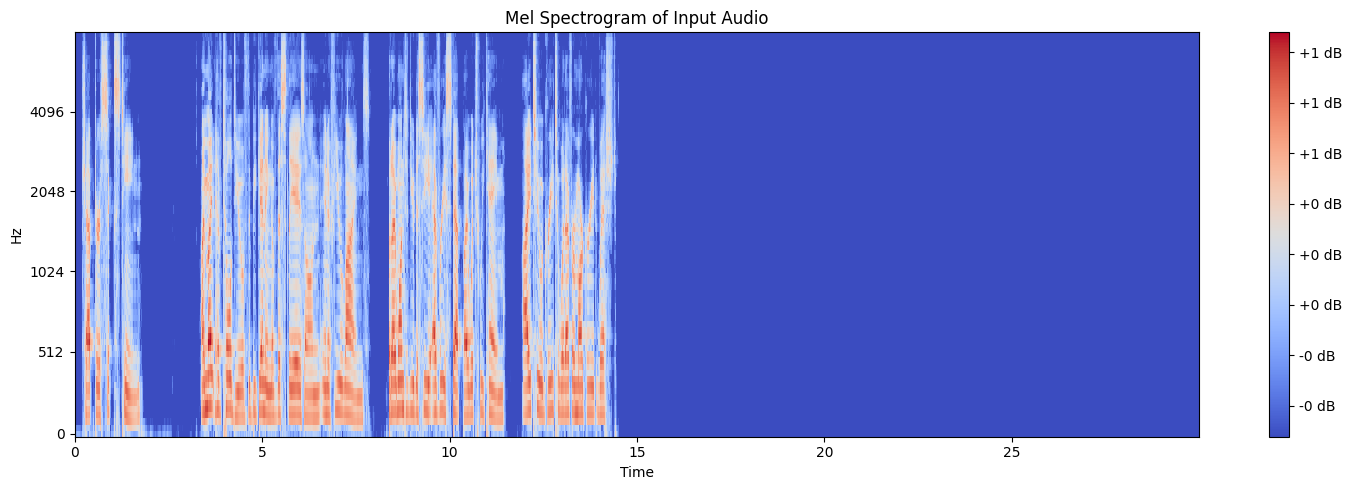

IndexError: tuple index out of range

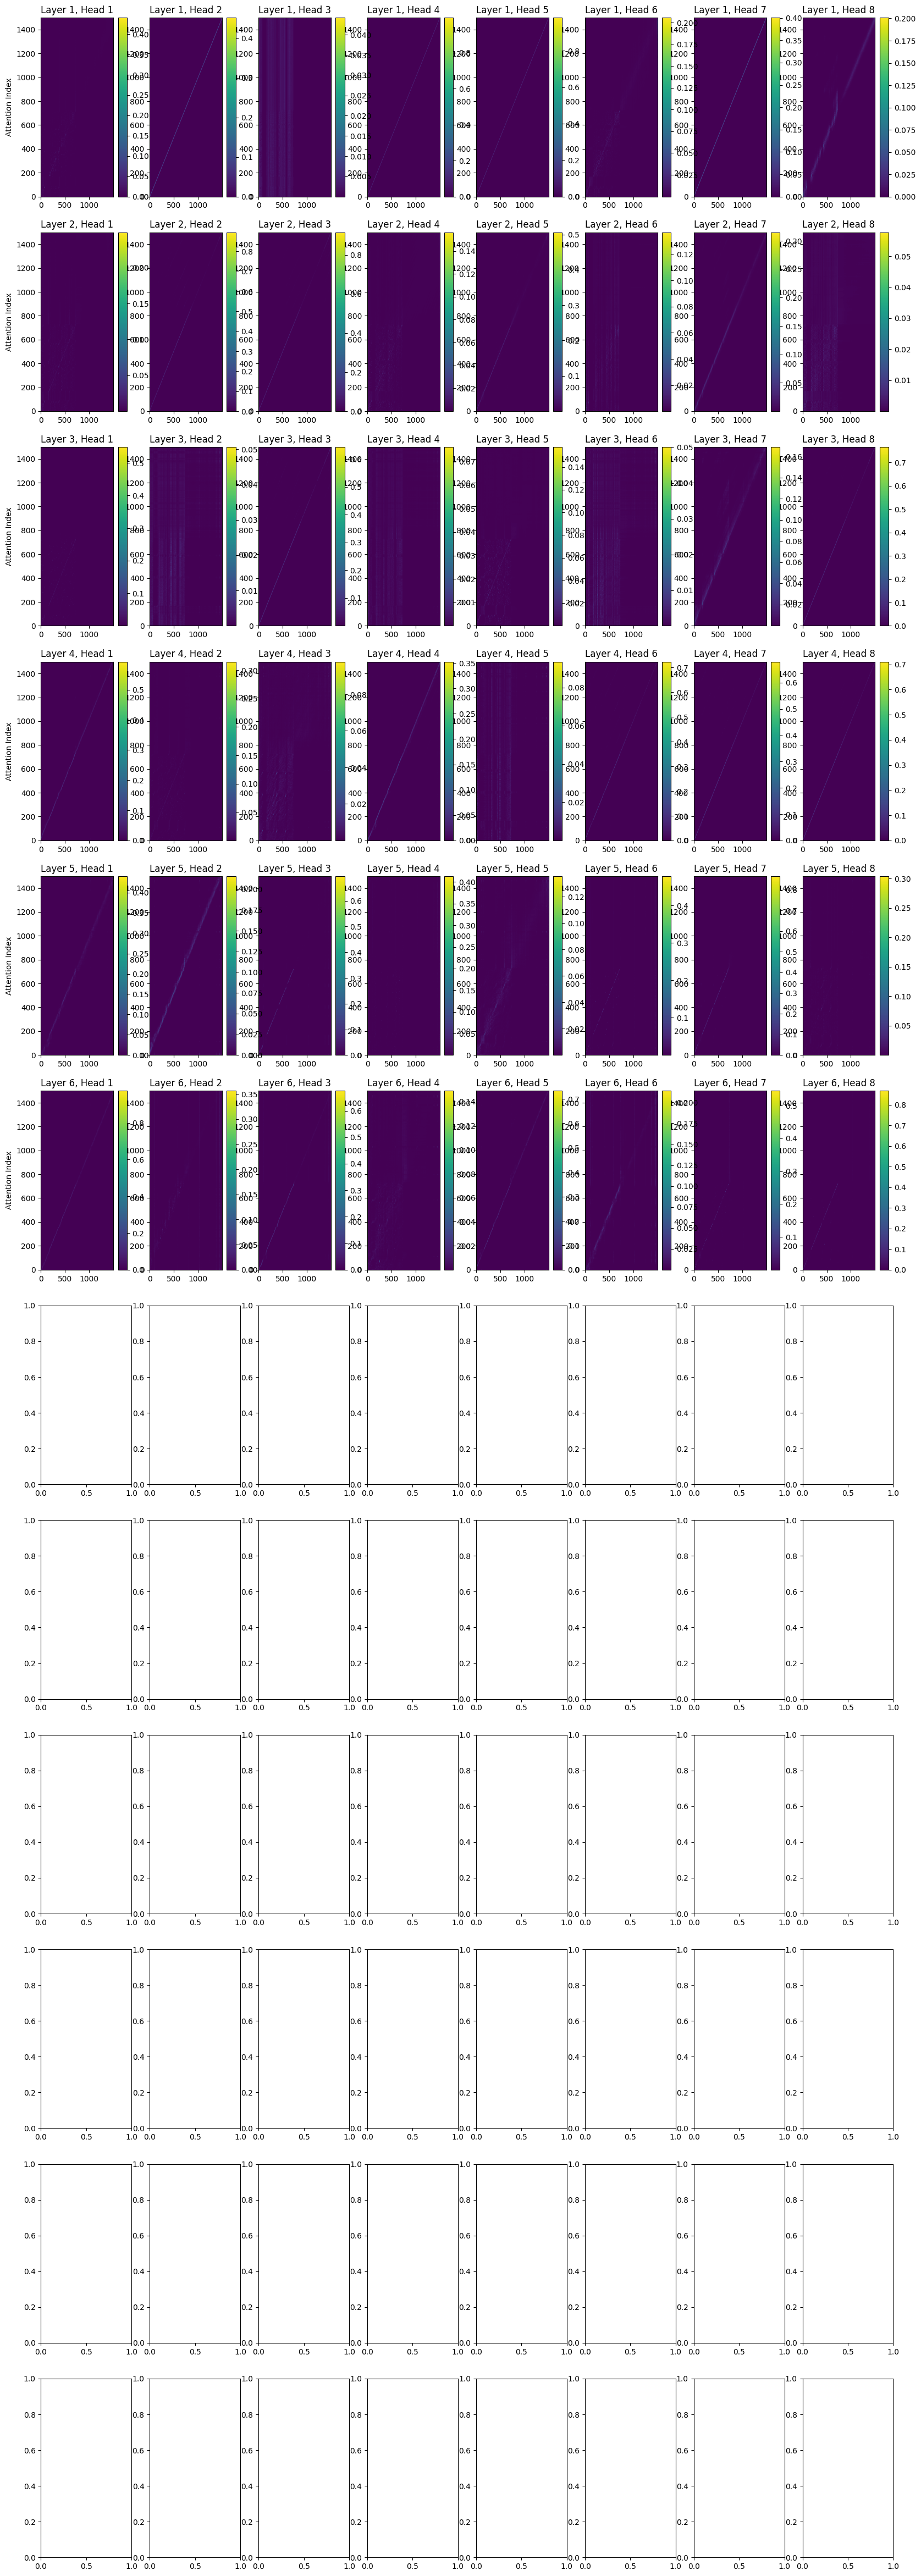

In [14]:
import torch
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from transformers import WhisperProcessor, WhisperForConditionalGeneration, WhisperTokenizer

def process_sample(sample, model, processor):
    input_features = sample["input_features"].unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model.model.encoder(
            input_features,
            attention_mask=None,
            output_attentions=True,
            output_hidden_states=True,
            return_dict=True
        )
    return {
        "input_features": input_features,
        "attention": outputs.attentions,
        "hidden_states": outputs.hidden_states
    }

def visualize_audio_features(input_features):
    mel_spec = input_features.squeeze().cpu().numpy()
    plt.figure(figsize=(15, 5))
    img = librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=16000, hop_length=160)
    plt.colorbar(img, format='%+2.0f dB')
    plt.title('Mel Spectrogram of Input Audio')
    plt.tight_layout()
    plt.show()

def visualize_multi_layer_head_attention(attention_weights, num_layers=12, num_heads=8):
    fig, axs = plt.subplots(num_layers, num_heads, figsize=(20, 5 * num_layers))
    for layer in range(num_layers):
        for head in range(num_heads):
            attention = attention_weights[layer][0, head].cpu().numpy()
            im = axs[layer, head].imshow(attention, aspect='auto', origin='lower')
            axs[layer, head].set_title(f'Layer {layer + 1}, Head {head + 1}')
            fig.colorbar(im, ax=axs[layer, head])
            if head == 0:
                axs[layer, head].set_ylabel('Attention Index')
            if layer == num_layers - 1:
                axs[layer, head].set_xlabel('Time Steps')
    plt.tight_layout()
    plt.show()

def analyze_early_layer_attention(attention_weights, num_layers=3):
    fig, axs = plt.subplots(1, num_layers, figsize=(20, 5))
    for layer in range(num_layers):
        attention = attention_weights[layer][0].mean(dim=0).cpu().numpy()
        im = axs[layer].imshow(attention, aspect='auto', origin='lower')
        axs[layer].set_title(f'Layer {layer + 1} Average Attention')
        fig.colorbar(im, ax=axs[layer])
        axs[layer].set_xlabel('Time Steps')
        if layer == 0:
            axs[layer].set_ylabel('Attention Index')
    plt.tight_layout()
    plt.show()

def analyze_individual_heads(attention_weights, layer=0, num_heads=8):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    for head in range(num_heads):
        attention = attention_weights[layer][0, head].cpu().numpy()
        row, col = head // 4, head % 4
        im = axs[row, col].imshow(attention, aspect='auto', origin='lower')
        axs[row, col].set_title(f'Layer {layer + 1}, Head {head + 1}')
        fig.colorbar(im, ax=axs[row, col])
        axs[row, col].set_xlabel('Time Steps')
        if col == 0:
            axs[row, col].set_ylabel('Attention Index')
    plt.tight_layout()
    plt.show()

def correlate_attention_with_audio(input_features, attention_weights, layer=0):
    mel_spec = input_features.squeeze().cpu().numpy()
    attention = attention_weights[layer][0].mean(dim=0).cpu().numpy()
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=16000, hop_length=160, ax=ax1)
    ax1.set_title('Mel Spectrogram')
    
    im = ax2.imshow(attention, aspect='auto', origin='lower')
    ax2.set_title(f'Layer {layer + 1} Average Attention')
    fig.colorbar(im, ax=ax2)
    
    mean_attention = attention.mean(axis=0)
    ax3.plot(mean_attention)
    ax3.set_title('Mean Attention Over Time')
    ax3.set_xlabel('Time Steps')
    ax3.set_ylabel('Mean Attention')
    
    plt.tight_layout()
    plt.show()

# Usage example
sample_index = 0
sample = processed_samples[sample_index]
sample_analysis = process_sample(sample, model, processor)

visualize_audio_features(sample_analysis["input_features"])
visualize_multi_layer_head_attention(sample_analysis["attention"])
analyze_early_layer_attention(sample_analysis["attention"])
analyze_individual_heads(sample_analysis["attention"])
correlate_attention_with_audio(sample_analysis["input_features"], sample_analysis["attention"])